In [89]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt


In [90]:
stock = 'MSTR'

In [91]:
#download the stock
data = yf.download(stock, start = '2014-01-01', end='2024-01-01')
data = data.reset_index()
data = data.set_index('Date')

[*********************100%%**********************]  1 of 1 completed


In [92]:
#Calculate the simple moving average for 20 days
def MA(df, period, column):
    return(data[column].rolling(window = period).mean())

In [93]:
#rename the adjclose column to aclose
data = data.rename(columns={'Adj Close': 'AClose'})

#Add new columns to the dataframe for the moving average
data['ma_20'] = MA(data,20,'AClose')
data['vol'] = data.AClose.rolling(20).std()
data['upper_bound'] = data.ma_20 + (2* data.vol)
data['lower_bound'] = data.ma_20 - (2* data.vol)
data['rsi'] = ta.rsi(data['AClose'],length=7)
data

,Open,High,Low,Close,AClose,Volume,ma_20,vol,upper_bound,lower_bound,rsi
Date,,,,,,,,,,,
2014-01-02,12.389000,12.518000,12.236000,12.353000,12.353000,751000,NaN,NaN,NaN,NaN,NaN
2014-01-03,12.367000,12.403000,12.271000,12.326000,12.326000,747000,NaN,NaN,NaN,NaN,NaN
2014-01-06,12.350000,12.417000,12.110000,12.144000,12.144000,508000,NaN,NaN,NaN,NaN,NaN
2014-01-07,12.167000,12.365000,12.144000,12.296000,12.296000,840000,NaN,NaN,NaN,NaN,NaN
2014-01-08,12.284000,12.347000,12.179000,12.244000,12.244000,645000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,58.195999,62.257999,57.869999,61.924000,61.924000,12620000,55.92590,3.445980,62.817860,49.033940,76.746449
2023-12-26,60.949001,61.555000,59.648998,60.389000,60.389000,12047000,56.46845,3.235067,62.938584,49.998316,65.041430
2023-12-27,61.380001,67.382004,61.201000,67.070999,67.070999,21273000,57.29265,3.721092,64.734835,49.850465,80.300219


<Axes: xlabel='Date'>

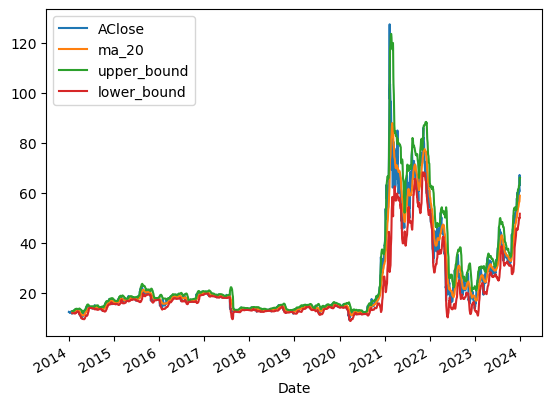

In [94]:
data[['AClose', 'ma_20','upper_bound','lower_bound']].plot()

In [95]:
conditions = [(data['rsi'] < 30),
(data['rsi'] > 70)]

conditions_2 = [(data['AClose'] < data['lower_bound']), (data['AClose'] > data['upper_bound'])]

conditions_3 = [(data['rsi'] < 30) & (data['AClose'] < data['lower_bound']),
(data['rsi'] > 70) & (data['AClose'] > data['upper_bound'])]
choices = ['buy','sell']

data['signal'] = np.select(conditions_3, choices)

data

,Open,High,Low,Close,AClose,Volume,ma_20,vol,upper_bound,lower_bound,rsi,signal
Date,,,,,,,,,,,,
2014-01-02,12.389000,12.518000,12.236000,12.353000,12.353000,751000,NaN,NaN,NaN,NaN,NaN,0
2014-01-03,12.367000,12.403000,12.271000,12.326000,12.326000,747000,NaN,NaN,NaN,NaN,NaN,0
2014-01-06,12.350000,12.417000,12.110000,12.144000,12.144000,508000,NaN,NaN,NaN,NaN,NaN,0
2014-01-07,12.167000,12.365000,12.144000,12.296000,12.296000,840000,NaN,NaN,NaN,NaN,NaN,0
2014-01-08,12.284000,12.347000,12.179000,12.244000,12.244000,645000,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,58.195999,62.257999,57.869999,61.924000,61.924000,12620000,55.92590,3.445980,62.817860,49.033940,76.746449,0
2023-12-26,60.949001,61.555000,59.648998,60.389000,60.389000,12047000,56.46845,3.235067,62.938584,49.998316,65.041430,0
2023-12-27,61.380001,67.382004,61.201000,67.070999,67.070999,21273000,57.29265,3.721092,64.734835,49.850465,80.300219,sell


In [96]:
data['signal']=data['signal'].shift()

In [97]:
#Methodology for tracking the buys and the sells
holding_position = False
buydates, selldates = [],[]
buyprice, sellprice = [],[]

for index, row in data.iterrows():
    if not holding_position and row['signal'] == 'buy':
        buydates.append(index)
        buyprice.append(row['Open'])
        holding_position = True

    if holding_position:
        if row['signal'] == 'sell' or row['Open'] < 0.95 * buyprice[-1]:
            selldates.append(index)
            sellprice.append(row['Open'])
            holding_position = False

if len(sellprice) < len(buyprice):
    sellprice.append(data.loc[data.index[-1], 'AClose'])
    selldates.append(data.index[-1])

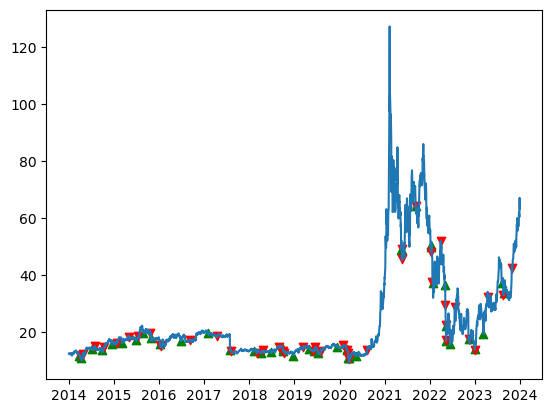

In [98]:
plt.plot(data['AClose'])
plt.scatter(data.loc[buydates].index, data.loc[buydates, 'AClose'], marker='^', color='g', label='Buy Signal')

# Scatter plot for sell signals
plt.scatter(data.loc[selldates].index, data.loc[selldates, 'AClose'], marker='v', color='r', label='Sell Signal')


In [99]:
# Calculate total buy and sell
total_buy = np.sum(buyprice)
total_sell = np.sum(sellprice)

# Calculate total percentage return
print(total_sell)
print(total_buy)
total_percentage_return = ((total_sell - total_buy) / total_buy) * 100.0
print(total_percentage_return)

927.0820026397705
911.7250022888184
1.6843895157420858
